# ВЫБОР ВИДЕОФАЙЛА ДЛЯ РАСПОЗНАВАНИЯ

In [27]:
link_to_video = "https://www.youtube.com/watch?v=x5EjzN8IdOA"

# или выберите видеофайл с компьютера
# from google.colab import files
# uploaded = files.upload()
# link_to_video = ['./' + str(name) for name in uploaded.keys()][0]

#СОЗДАНИЕ КФГ ДЛЯ УДОБСТВА ОБНОВЛЕНИЯ ДАННЫХ

In [28]:
import os
# config
class SetupCFG:
  def __init__(self, dataset_name, path_to_dataset, json_name, path_to_weights, path_to_mask, \
               work_dir, video_file_name, video_file_name_to_save, temporary_storage):
    self.dataset_name = dataset_name
    self.path_to_dataset = path_to_dataset
    self.path_to_json = os.path.join(path_to_dataset, json_name)    
    self.path_to_weights = path_to_weights
    self.path_to_mask = path_to_mask
    self.work_dir = work_dir
    self.video_file_name = video_file_name
    self.video_file_name_to_save = video_file_name_to_save if temporary_storage else os.path.join(work_dir, video_file_name_to_save)
    self.temporary_storage = temporary_storage

my_cfg = SetupCFG(dataset_name = "my_dataset2", 
                  path_to_dataset = "./drive/My Drive/Colab Notebooks/KomPol2_clean", 
                  json_name = "KomPol2-7.json", 
                  work_dir = "drive/My Drive/Colab Notebooks/output_Pol",                  
                  path_to_weights = "drive/My Drive/Colab Notebooks/output_Pol/model_final_poliklinika_total_loss_0.9683.pth",
                  #"drive/My Drive/Colab Notebooks/output_Pol/model_final_poliklinika.pth",
                  path_to_mask = "drive/My Drive/Colab Notebooks/My_files_detectron2/mask.png",
                  video_file_name = "video.mp4",
                  video_file_name_to_save = "video_final.mp4", 
                  temporary_storage = True)

# УСТАНОВКА ВСЕГО НЕОБХОДИМОГО

In [29]:
# %%capture
# !pip3 uninstall Pillow # for colab image_show

In [30]:
!pip3 install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (8.0.1)


In [31]:
%%capture
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [32]:
%%capture
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [33]:
from google.colab import drive
drive.mount('/content/drive')
# path_to_weights = "drive/My Drive/Colab Notebooks/output_Pol/model_final_poliklinika.pth"
# if not os.path.exists("./model_final.pth"):  
  #скачиваем обученные веса

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ИМПОРТ ВСЕГО НЕОБХОДИМОГО

In [34]:
%%capture
import torch, torchvision
import detectron2

import numpy as np
import cv2
import random
from IPython.display import Image 
from google.colab.patches import cv2_imshow

# для регистрации данных
from detectron2.data.datasets import register_coco_instances

# для обучения
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# для предиктора
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# для предсказания фото
from detectron2.utils.visualizer import ColorMode

# для предсказания видео
from IPython.display import YouTubeVideo, display
import tqdm
from detectron2.utils.video_visualizer import VideoVisualizer

import copy

# РЕГИСТРАЦИЯ МЕТАДАННЫХ ДАТАСЕТА

In [35]:
# MetadataCatalog.clear()
# MetadataCatalog.list()
# DatasetCatalog._REGISTERED #.pop('my_dataset')

In [36]:
register_coco_instances(my_cfg.dataset_name, {}, my_cfg.path_to_json, my_cfg.path_to_dataset)
MetadataCatalog.get(my_cfg.dataset_name).thing_classes = ['car', 'minibus', 'trolleybus', 'tram', 'truck', 'bus', 'middle_bus', 'ambulance', 'fire_truck', 'middle_truck', 'tractor', 'uncategorized', 'van', 'person']
dataset_metadata = MetadataCatalog.get(my_cfg.dataset_name)

AssertionError: ignored

#ТРЕНИРОВКА

In [37]:
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")) #LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml
# cfg.DATASETS.TRAIN = (my_cfg.dataset_name,)
# cfg.DATASETS.TEST = (my_cfg.dataset_name,)
# cfg.DATALOADER.NUM_WORKERS = 8
# cfg.MODEL.WEIGHTS = my_cfg.path_to_weights
# # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo 
# cfg.SOLVER.IMS_PER_BATCH = 5
# cfg.SOLVER.BASE_LR = 0.025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512) 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 #10 
# # cfg.MODEL.RETINANET.PRIOR_PROB = 1


# os.makedirs("./output", exist_ok=True) # cfg.OUTPUT_DIR
# cfg.OUTPUT_DIR = "./output"
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [38]:
# !cp "output/model_final.pth" "drive/My Drive/Colab Notebooks/output_Pol/model_final_poliklinika_total_loss_0.852.pth"

# СОЗДАНИЕ ПРЕДИКТОРА ИЗОБРАЖЕНИЯ

In [39]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("LVISv0.5-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")) # получение используемой модели 
cfg.MODEL.WEIGHTS = my_cfg.path_to_weights #"model_final.pth" # путь к найденным лучшим весам модели
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # установить порог распознавания объекта в 50% (объекты, распознанные с меньшей вероятностью не будут учитываться)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 # число классов для распознавания

predictor = DefaultPredictor(cfg) 

# ПРЕДСКАЗАНИЕ ФОТО

In [40]:
%%capture
!wget https://i.ibb.co/J5FXD1Y/out.png

In [41]:
def apply_mask(image, mask, color, alpha=0.5):
  """Apply the given mask to the image.
  """
  for c in range(3):
    image[:, :, c] = np.where(mask == 0, \
            image[:, :, c] * \
            (1 - alpha) + alpha * color[c] * 255, \
            image[:, :, c])
  return image

In [42]:
def create_mask(path_to_mask, w,h):
  mask = cv2.imread(path_to_mask,cv2.IMREAD_GRAYSCALE) #"drive/My Drive/Colab Notebooks/My_files_detectron2/mask.png"
  # h,w = mask.shape
  # print(h,w)
  mask = cv2.resize(mask, dsize=(w, h))
  mask = mask.astype(np.bool)
  return mask

In [43]:
import copy
from IPython.display import clear_output

In [44]:
im = cv2.imread("out.png")
h,w,_ = im.shape
# print(h,w)
mask = create_mask(my_cfg.path_to_mask, w,h)
im_with_mask = apply_mask(copy.deepcopy(im),mask,[0,0,0],1)

outputs = predictor(im_with_mask)
# print(outputs)
v = Visualizer(im[:, :, ::-1],
                dataset_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE   
)
clear_output()
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [45]:
!ls

drive	 out.png.1  sample_data			video_final.mp4
out.png  out.png.2  video_final_compressed.mp4	video.mp4


# ПРЕДСКАЗАНИЕ ВИДЕО

In [46]:
# !youtube-dl --list-formats -i $link_to_video

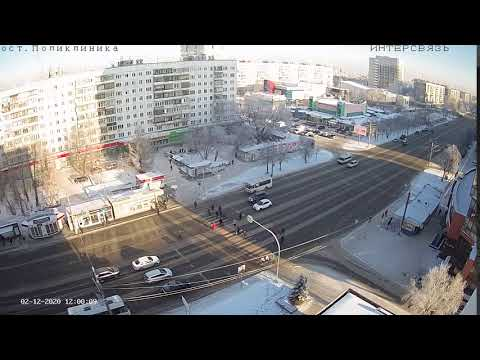

https://www.youtube.com/watch?v=x5EjzN8IdOA
[youtube] x5EjzN8IdOA: Downloading webpage
[youtube] x5EjzN8IdOA: Downloading MPD manifest
[download] video.mp4 has already been downloaded
[download] 100% of 1.30MiB


In [47]:
if link_to_video[0] != '.':
  # Отобразим выбранное видео из ютуба
  video_id = link_to_video.split('v=')[1]
  video = YouTubeVideo(video_id, width=500)
  display(video)
  print(link_to_video)
  # Скачаем это видео с ютуба
  !pip install youtube-dl
  !youtube-dl $link_to_video -o video.mp4 -f 22 #137
else:
  # Изменим имя и формат на 'video.mp4'
  !ffmpeg -i $link_to_video video.mp4

In [48]:
# Функции, необходимые для обработки видеофайла
def _frame_from_video(video):
  while video.isOpened():
      success, frame = video.read()
      if success:         
          yield frame
      else:
        break
def run_on_video(video):
        video_visualizer = VideoVisualizer(dataset_metadata, ColorMode.IMAGE)

        def process_predictions(frame, predictions):
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            predictions = predictions["instances"].to("cpu")
            vis_frame = video_visualizer.draw_instance_predictions(frame, predictions)
            # Converts Matplotlib RGB format to OpenCV BGR format
            vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
            return vis_frame

        frame_gen = _frame_from_video(video)
        for frame in frame_gen:          
          frame_with_mask = apply_mask(copy.deepcopy(frame),mask,[0,0,0],1)          
          yield process_predictions(frame, predictor(frame_with_mask))

In [49]:
# Предсказание видео
video = cv2.VideoCapture("video.mp4")
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

mask = create_mask(my_cfg.path_to_mask, w,h)

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
output_file = cv2.VideoWriter(my_cfg.video_file_name_to_save, fourcc, fps, (w,h), True)

frame_gen = _frame_from_video(video)

for vis_frame in tqdm.tqdm(run_on_video(video), total=num_frames):
  output_file.write(vis_frame)  
video.release()
output_file.release()

100%|██████████| 249/249 [01:24<00:00,  2.96it/s]


# ОТОБРАЖЕНИЕ ВИДЕО

In [50]:
%%capture
# сожмем видеофайл для возможности отображения видео прямо в Colab
if os.path.exists("./video_final_compressed.mp4"):
  !rm video_final_compressed.mp4 
!ffmpeg -i video_final.mp4 -q:v 4 video_final_compressed.mp4   

In [51]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video_final_compressed.mp4','rb').read()
data_url = "data:video_final_compressed/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1100 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# СКАЧИВАНИЕ ВИДЕОФАЙЛА

In [52]:
# Раскомментируйте для скачивания видеофайла
# from google.colab import files
# files.download(my_cfg.video_file_name_to_save)